In [1]:
!pip install hopsworks requests pandas numpy scikit-learn shap

In [2]:
!pip install confluent-kafka

In [6]:
!pip install hopsworks==4.2.*

In [62]:
import requests
from datetime import datetime

In [ ]:
import os
import pandas as pd

# Load full dataset
import pandas as pd

df = pd.read_csv("karachi_aqi_last1year.csv")
df['date'] = pd.to_datetime(df['date'])

df.columns = df.columns.str.strip()

def calculate_aqi_pm25(pm25):
    if pm25 <= 12:
        return (50 / 12) * pm25
    elif pm25 <= 35.4:
        return 50 + ((pm25 - 12.1) / (35.4 - 12.1)) * 50
    elif pm25 <= 55.4:
        return 100 + ((pm25 - 35.5) / (55.4 - 35.5)) * 50
    elif pm25 <= 150.4:
        return 150 + ((pm25 - 55.5) / (150.4 - 55.5)) * 100
    else:
        return 300

df['aqi'] = df['pm25'].apply(calculate_aqi_pm25)
df = df.sort_values('date')

df['aqi_lag_1'] = df['aqi'].shift(1)
df['aqi_lag_3'] = df['aqi'].shift(3)
df['aqi_change_rate'] = df['aqi'].pct_change()

df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

df = df.dropna()

# Save features TO DRIVE
df.to_csv("karachi_aqi_features.csv", index=False)

df.head()

project = hopsworks.login(
    api_key_value=os.getenv("HOPSWORKS_API_KEY"),
    project="AQIPred"
)

fs = project.get_feature_store()

feature_group = fs.create_feature_group(
    name="karachi_aqishine_fg",
    description="AQI features for Karachi",
    version=1,
    primary_key=["date"],
    online_enabled=True
)

df = pd.read_csv("karachi_aqi_features.csv")
feature_group.insert(df, write_options={"wait_for_job": True})

Connection closed.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1357973
Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1357973/fs/1341507/fg/1984902


Uploading Dataframe: 100.00% |██████████| Rows 277/277 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: karachi_aqishine_fg_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1357973/jobs/named/karachi_aqishine_fg_1_offline_fg_materialization/executions


(Job('karachi_aqishine_fg_1_offline_fg_materialization', 'SPARK'), None)

In [63]:
fg = fs.get_feature_group(
    name="karachi_aqishine_fg",
    version=1
)

In [65]:
df_fs = fg.read()
print(df_fs.tail())

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.70s) 
           date  pm25         aqi   aqi_lag_1   aqi_lag_3  aqi_change_rate  \
272  2025-01-07   151  300.000000  300.000000  216.912540         0.000000   
273  2024-09-09    67  162.118019  155.795574  166.332982         0.040582   
274  2024-08-14    63  157.903056  163.171760  133.919598        -0.032289   
275  2024-07-29    97  193.730242  191.622761  194.783983         0.010998   
276  2024-10-11   135  233.772392  207.428872  221.127503         0.127000   

     month  day_of_week  is_weekend  
272      1            1           0  
273      9            0           0  
274      8            2           0  
275      7            0           0  
276     10            4           0  


In [66]:
# List of feature names
feature_names = [f.name for f in fg.features]
print(feature_names)


['date', 'pm25', 'aqi', 'aqi_lag_1', 'aqi_lag_3', 'aqi_change_rate', 'month', 'day_of_week', 'is_weekend']


In [68]:
print(df_fs.columns)

Index(['date', 'pm25', 'aqi', 'aqi_lag_1', 'aqi_lag_3', 'aqi_change_rate',
       'month', 'day_of_week', 'is_weekend'],
      dtype='object')


In [72]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Sort by time (important for time series)
df_fs = df_fs.sort_values("date")

# -----------------
# TARGET
# -----------------
y = df_fs["aqi"]

# -----------------
# FEATURES
# -----------------
X = df_fs.drop(columns=["aqi", "date"])

# Time-based split
split = int(len(df_fs) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Scale for linear & NN
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


In [73]:
# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print("RF MSE:", mean_squared_error(y_test, rf_pred))
print("RF R2:", r2_score(y_test, rf_pred))

RF MSE: 0.9378893084809921
RF R2: 0.9995728470339037


In [74]:
# ridge regression
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_s, y_train)

ridge_pred = ridge.predict(X_test_s)

print("Ridge MSE:", mean_squared_error(y_test, ridge_pred))
print("Ridge R2:", r2_score(y_test, ridge_pred))


Ridge MSE: 263.8772951154101
Ridge R2: 0.8798195391772071


In [75]:
# neural network
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_s.shape[1],)),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

history = model.fit(
    X_train_s, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    verbose=0
)

nn_pred = model.predict(X_test_s).flatten()

print("NN MSE:", mean_squared_error(y_test, nn_pred))
print("NN R2:", r2_score(y_test, nn_pred))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
NN MSE: 2331.386449885062
NN R2: -0.06180828396265947


In [78]:
from sklearn.metrics import mean_absolute_error

# Random Forest
mae_rf = mean_absolute_error(y_test, rf_pred)
print("Random Forest MAE:", mae_rf)

# Ridge Regression
mae_ridge = mean_absolute_error(y_test, ridge_pred)
print("Ridge Regression MAE:", mae_ridge)

# Neural Network
mae_nn = mean_absolute_error(y_test, nn_pred)
print("Neural Network MAE:", mae_nn)

Random Forest MAE: 0.4944709970395889
Ridge Regression MAE: 11.554216685407836
Neural Network MAE: 38.81885780456212


In [80]:
print(f"{'Model':<20} {'MSE':<10} {'R2':<10} {'MAE':<10}")
print(f"{'Random Forest':<20} {mean_squared_error(y_test, rf_pred):<10.2f} {r2_score(y_test, rf_pred):<10.2f} {mae_rf:<10.2f}")
print(f"{'Ridge Regression':<20} {mean_squared_error(y_test, ridge_pred):<10.2f} {r2_score(y_test, ridge_pred):<10.2f} {mae_ridge:<10.2f}")
print(f"{'Neural Network':<20} {mean_squared_error(y_test, nn_pred):<10.2f} {r2_score(y_test, nn_pred):<10.2f} {mae_nn:<10.2f}")


Model                MSE        R2         MAE       
Random Forest        0.94       1.00       0.49      
Ridge Regression     263.88     0.88       11.55     
Neural Network       2331.39    -0.06      38.82     


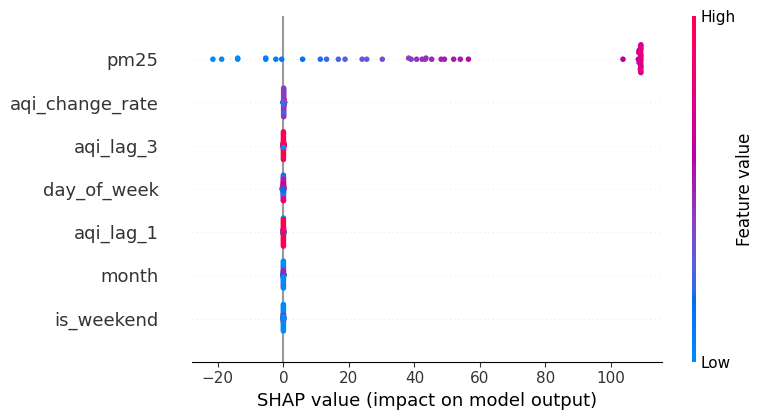

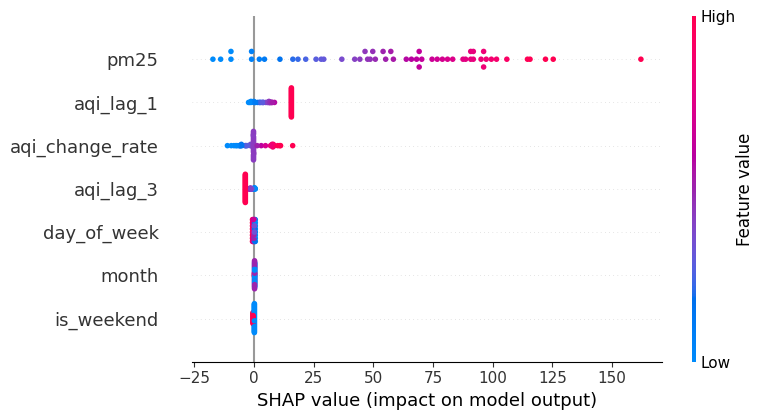

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/s

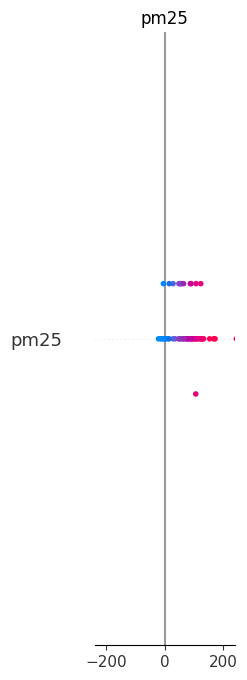

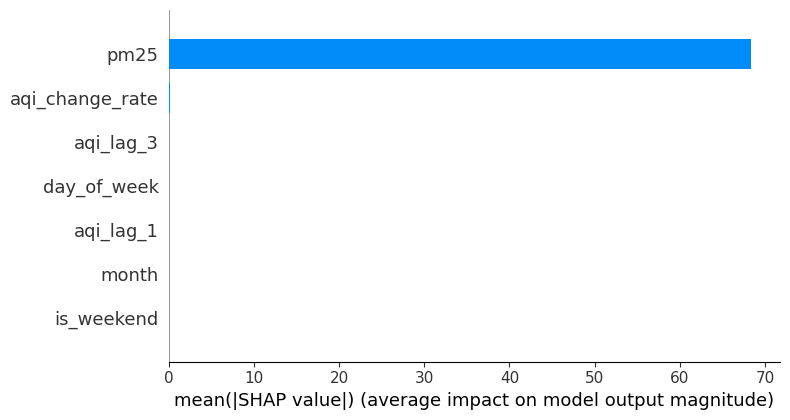

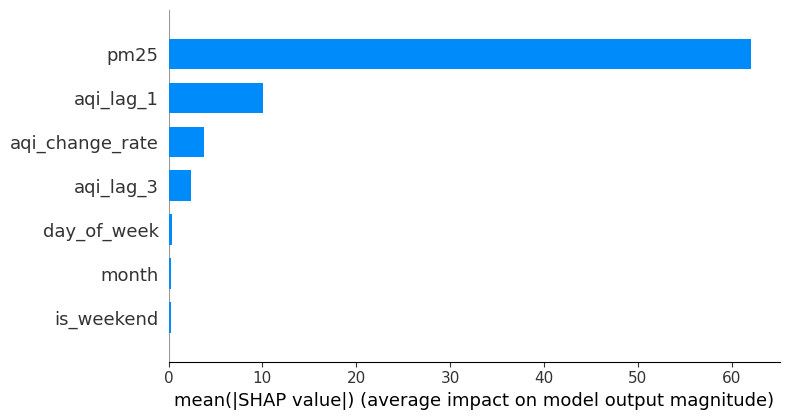

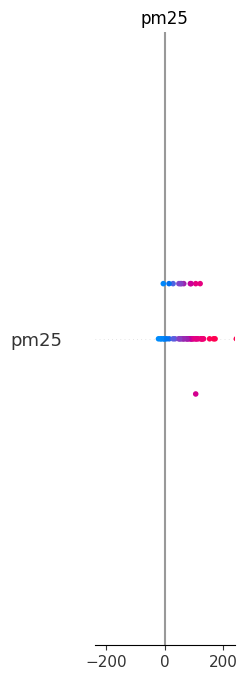

In [77]:
import shap

X_test_shap = X_test.copy()

#random forest
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test_shap)
shap.summary_plot(shap_values_rf, X_test_shap, feature_names=X_test.columns)

#ridge regression
explainer_ridge = shap.LinearExplainer(ridge, X_train_s)
shap_values_ridge = explainer_ridge.shap_values(X_test_s)
shap.summary_plot(shap_values_ridge, X_test_s, feature_names=X_test.columns)

#neural ntw
X_bg = shap.sample(X_train_s, 100)
X_test_small = shap.sample(X_test_s, 50)
explainer_nn = shap.KernelExplainer(model.predict, X_bg)
shap_values_nn = explainer_nn.shap_values(X_test_small)
shap.summary_plot(shap_values_nn, X_test_small, feature_names=X_test.columns)

shap.summary_plot(shap_values_rf, X_test_shap, plot_type="bar", feature_names=X_test.columns)
shap.summary_plot(shap_values_ridge, X_test_s, plot_type="bar", feature_names=X_test.columns)
shap.summary_plot(shap_values_nn, X_test_small, plot_type="bar", feature_names=X_test.columns)
